# Familiarisation avec les données

## Deux types de données
 
**Raster**:

* utilise une matrice de zones carrées, des pixels, dont la taille détermine le détail qui peut être conservé dans le jeu de données
* la valeur d'un pixel peut être continue (ex: altitude) ou catégorielle (ex: utilisation des terres)
* décrit l'intérieur des entitiés cartographiques
* utile pour capturer, stocker et analyser des données qui varient continuellement d'un endroit à l'autre (altitude, température, pH du sol, etc.)

**Vector**:

* utilise des coordonnées _x_ et _y_ pour définir la forme et l'emplacement des zones correspondant aux entités cartographiques
* un vecteur peut être un point (ex: point d'intérêt), une ligne (ex: route) ou un polygone (ex: lac)
* décrit le centre et les bords des entités
* utile pour capturer et stocker des détails spatiaux

https://mapasyst.extension.org/what-is-the-difference-between-raster-and-vector-data/#:~:text=Vector%20data%20are%20excellent%20for,store%20aerial%20and%20satellite%20imagery.

https://carpentries-incubator.github.io/geospatial-python/aio/index.html

## De quelles informations disposons-nous ?

Voir _V. Product description_ du manuel d'utilisation, en particulier _V.I.II. Nomenclature_ et _V.II. CLC status layer products_.

## Exploration des données

### Vector

In [38]:
import geopandas as gpd
import numpy as np

In [39]:
# clc = gpd.read_file("data/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg")

Impossible de lire tout le fichier _.gpkg_ d'un coup car le programme plante. Il faut extraire des zones à l'aide de `QGIS`.


In [40]:
gdf = gpd.read_file("data/france-zone-1.gpkg")
gdf.head()

,OBJECTID,Code_18,Remark,Area_Ha,ID,geometry
0,458367,111,None,32.684892,EU_458367,"MULTIPOLYGON (((3764057.100 2879442.440, 37638..."
1,464474,112,None,674.856306,EU_464474,"MULTIPOLYGON (((3772518.090 2869459.160, 37724..."
2,464486,112,None,125.582284,EU_464486,"MULTIPOLYGON (((3751235.850 2867880.030, 37509..."
3,464494,112,None,44.825253,EU_464494,"MULTIPOLYGON (((3753121.110 2869761.200, 37531..."
4,464503,112,None,30.711344,EU_464503,"MULTIPOLYGON (((3749222.430 2870367.950, 37491..."


In [41]:
def preprocessing(gdf):
    # utilisation de l'air calculée par geopandas
    gdf["Area_Ha"] = gdf.area/1e4
    # todo : gérer les nodata
    return gdf

In [42]:
gdf = preprocessing(gdf)

In [43]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   OBJECTID  692 non-null    int64   
 1   Code_18   692 non-null    object  
 2   Remark    0 non-null      object  
 3   Area_Ha   692 non-null    float64 
 4   ID        692 non-null    object  
 5   geometry  692 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 32.6+ KB


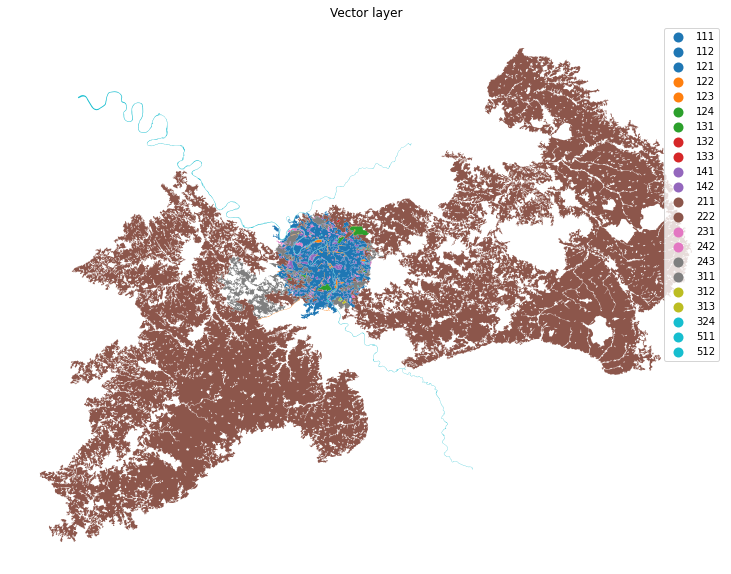

In [44]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(20, 10))
gdf.plot(column="Code_18", legend=True, ax=ax)
ax.set(title="Vector layer")
ax.set_axis_off()
plt.show()

#### Codes

In [45]:
gdf.Code_18.value_counts()

121    155
141     93
142     78
112     70
211     49
242     46
311     44
122     37
231     32
512     18
111     15
324     12
243      9
222      7
133      7
124      6
131      5
132      3
313      2
123      2
312      1
511      1
Name: Code_18, dtype: int64

<BarContainer object of 22 artists>

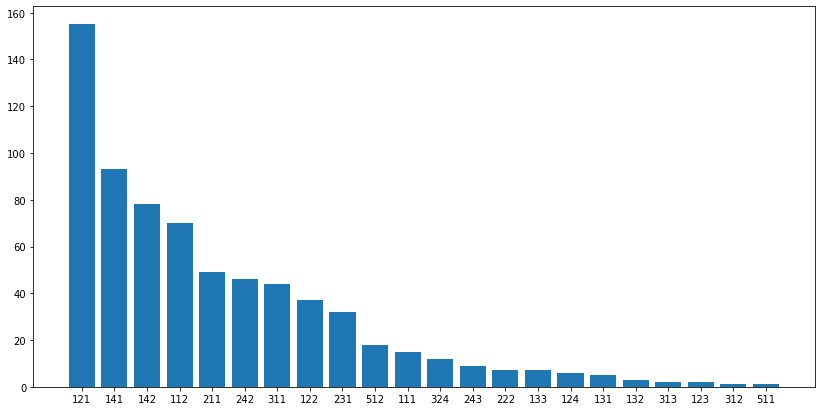

In [46]:
plt.figure(figsize=(14,7))
plt.bar(gdf.Code_18.value_counts().index, gdf.Code_18.value_counts())

#### Area

In [47]:
gdf.Area_Ha.describe()

count    6.920000e+02
mean     3.730443e+03
std      6.120669e+04
min      2.502368e+01
25%      3.299732e+01
50%      5.519455e+01
75%      1.256282e+02
max      1.140250e+06
Name: Area_Ha, dtype: float64

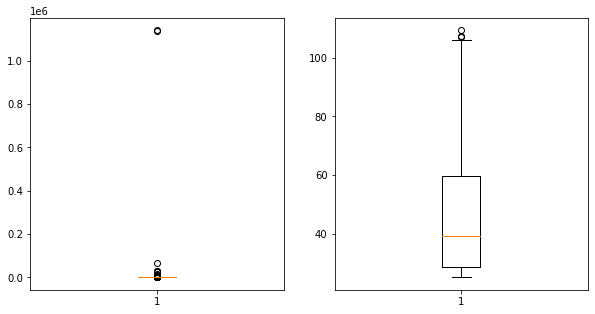

In [48]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(gdf.Area_Ha)
plt.subplot(122)
plt.boxplot(gdf.Area_Ha[gdf.Area_Ha < 110])
plt.show()

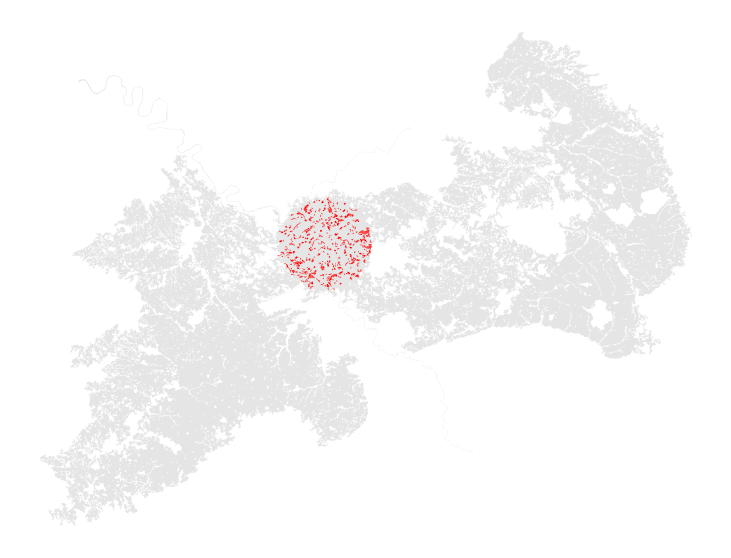

In [49]:
gdf_area_low = gdf[gdf.Area_Ha < 125]
gdf_area_high = gdf[gdf.Area_Ha >= 125]
f, ax = plt.subplots(figsize=(20, 10))
gdf_area_low.plot(ax=ax, color = "red")
gdf_area_high.plot(ax=ax, color="black", alpha = 0.1)
ax.set_axis_off()
plt.show()

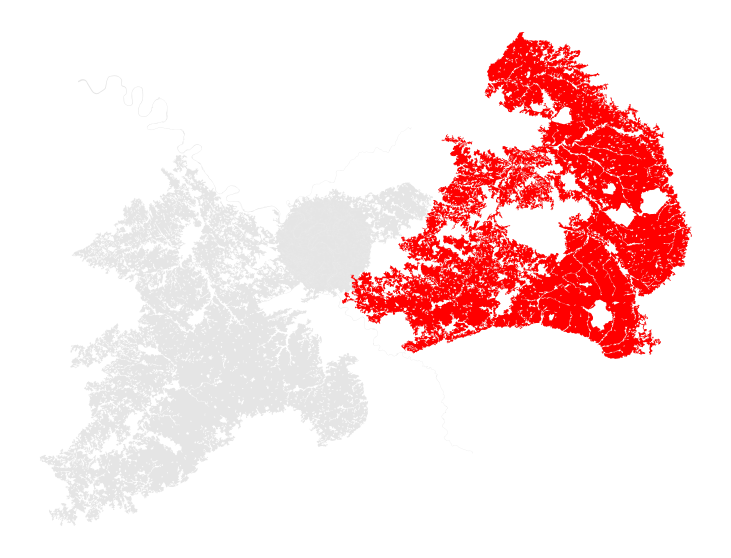

In [50]:
f, ax = plt.subplots(figsize=(20, 10))

gdf.plot(ax=ax, color = "black", alpha = 0.1)
gdf[gdf.Area_Ha == max(gdf.Area_Ha)].plot(ax=ax, color = "red")
ax.set_axis_off()
plt.show()

#### Voisinage

In [51]:
import shapely
import pandas as pd

def preprocess_border(area, border):
    if border.is_empty:
        return border
    # overlap
    if border.geom_type == "Polygon":
        border = border.difference(area.geometry).intersection(area.geometry)
    elif border.geom_type == "MultiPolygon":
        border = border.geoms.difference(area.geometry).intersection(area.geometry)
    # plusieurs frontières
    if border.geom_type == "MultiLineString":
        border = shapely.ops.linemerge(border)
    return border

def calc_borders_length(area, neighbors):
    border_lengths = {"total_borders":[], "greatest_borders":[], "nb_borders":[]}
    borders = neighbors.geometry.intersection(area.geometry)
    for border in borders:
        border = preprocess_border(area, border)
        if border.geom_type == "MultiLineString" and not border.is_empty:
            lengths = gpd.GeoSeries(border.geoms).length
            border_lengths["total_borders"].append(lengths.sum())
            border_lengths["greatest_borders"].append(max(lengths))
            border_lengths["nb_borders"].append(len(lengths))
        else:
            length = border.length
            border_lengths["total_borders"].append(length)
            border_lengths["greatest_borders"].append(length)
            border_lengths["nb_borders"].append(1 if length > 0 else 0)
    return border_lengths

def calc_neighborhood(gdf, path = None):
    neighbors_df = pd.DataFrame(columns=["src", "dest", "distance", "total_border", "greatest_border", "nb_border"])

    for index, area in gdf.iterrows():
        print(f"{index}", end="...")

        distances = gdf.geometry.distance(area.geometry)
        # ! prend en compte l'overlapping
        neighbors = gdf[(distances < 10) & (gdf.OBJECTID != area.OBJECTID)]

        src = np.ones(len(neighbors), dtype=np.int64) * area.OBJECTID
        dest = neighbors.OBJECTID.tolist()
        distance = distances[neighbors.index].tolist()

        # ! peut avoir plusieurs frontières
        # version 1 : somme des frontières
        # total_borders = neighbors.geometry.intersection(area.geometry).length.tolist()
        # version 2 : la plus grande, la somme et le nombre de frontières
        borders = calc_borders_length(area, neighbors)

        df = pd.DataFrame({"src":src, "dest": dest, "distance": distance, "total_border": borders["total_borders"], "greatest_border": borders["greatest_borders"], "nb_border": borders["nb_borders"]})

        neighbors_df = pd.concat([neighbors_df, df])

    print("finished")

    if path is not None:
        neighborhood.to_csv(path)

    return neighbors_df

In [52]:
neighborhood = calc_neighborhood(gdf, "data/france-zone-1-neighborhood.csv")

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...119...120...121...122...123...124...125...126...127...128...129...130...131...132...133...134...135...136...137...138...139...140...141...142...143...144...145...146...147...148...149...150...151...152...153...154...155...156...157...158...159...160...161...162...163...164...165...166...167...168...169...170...171...172...173...174...175...176...177...178...179...180...181...182...183...184...

In [53]:
neighborhood.head()

,src,dest,distance,total_border,greatest_border,nb_border
0,458367,465724,0.0,202.413571,202.413571,1
1,458367,597183,0.0,1851.487084,1851.487084,1
2,458367,597195,0.0,571.23882,571.23882,1
3,458367,597383,0.0,441.460743,441.460743,1
0,464474,466354,0.0,6967.211402,5415.288413,2


In [54]:
neighborhood.loc[:,"distance":"nb_border"].describe()

,distance,total_border,greatest_border,nb_border
count,3152.0,3152.0,3152.0,3152
unique,2.0,2250.0,2263.0,10
top,0.0,0.0,0.0,1
freq,3150.0,22.0,22.0,2784


In [55]:
neighborhood[neighborhood.distance > 0]

,src,dest,distance,total_border,greatest_border,nb_border
1,547381,548579,1.724094,0.0,0.0,0
1,548579,547381,1.724094,0.0,0.0,0


Il semble y avoir un couple de voisins légèrement éloignés, mais il faut vérifier qu'ils sont effectivement voisins en vérifiant qu'il n'y a pas un autre terrain entre les deux par exemple.

<AxesSubplot:>

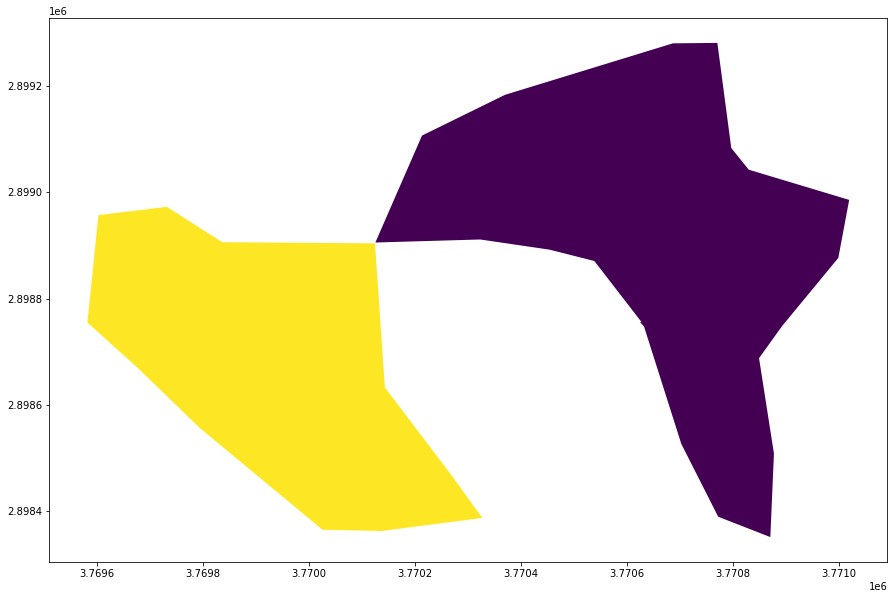

In [56]:
distanced_neighbors = neighborhood[neighborhood.distance > 0].src.tolist()
df = gdf[gdf.OBJECTID.isin(distanced_neighbors)]
f, ax = plt.subplots(figsize=(20, 10))
df.plot("OBJECTID", ax=ax)

In [57]:
n1 = df.iloc[0]
n1_geo = gpd.GeoSeries(n1.geometry).translate(-400)

df.iloc[1].geometry.distance(n1_geo.iloc[0])

0.0

<AxesSubplot:>

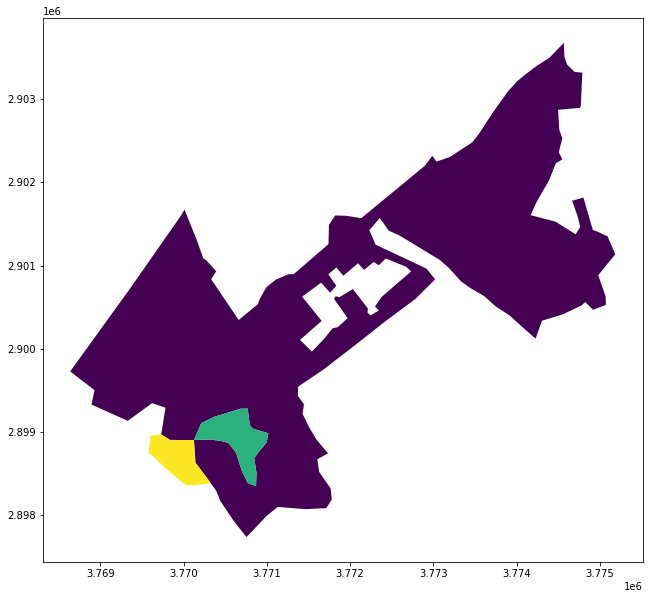

In [58]:
neighbors_547381 = neighborhood[neighborhood.src == 547381].dest.tolist()
df = gdf[gdf.OBJECTID.isin(neighbors_547381 + [547381])]
f, ax = plt.subplots(figsize=(20, 10))
df.plot("OBJECTID", ax=ax)

Les aires sont très légèrement éloignées mais elles sont séparées par une autre aire. Il faudrait calculer le voisinage sur d'autre zones pour voir si le phénomène se reproduit. Il s'agit néanmoins de l'unique cas où le phénomène apparaît sur 692 instances.

### Raster

In [59]:
attributes = gpd.read_file("data/clc/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif.vat.dbf")
attributes

,Value,Count,LABEL3,Red,Green,Blue,CODE_18,geometry
0,1,800699.0,Continuous urban fabric,0.901961,0.000000,0.301961,111,None
1,2,17085234.0,Discontinuous urban fabric,1.000000,0.000000,0.000000,112,None
2,3,3210212.0,Industrial or commercial units,0.800000,0.301961,0.949020,121,None
3,4,414626.0,Road and rail networks and associated land,0.800000,0.000000,0.000000,122,None
4,5,122685.0,Port areas,0.901961,0.800000,0.800000,123,None
5,6,352020.0,Airports,0.901961,0.800000,0.901961,124,None
6,7,820443.0,Mineral extraction sites,0.650980,0.000000,0.800000,131,None
7,8,125373.0,Dump sites,0.650980,0.301961,0.000000,132,None
8,9,201018.0,Construction sites,1.000000,0.301961,1.000000,133,None
9,10,330596.0,Green urban areas,1.000000,0.650980,1.000000,141,None


Les données raster contiennent les attributs rouge, vert et bleu mais pas infrarouge.

Geopandas ne gère pas les données raster, il faut un outil pour les exploiter: `rioxarray`.

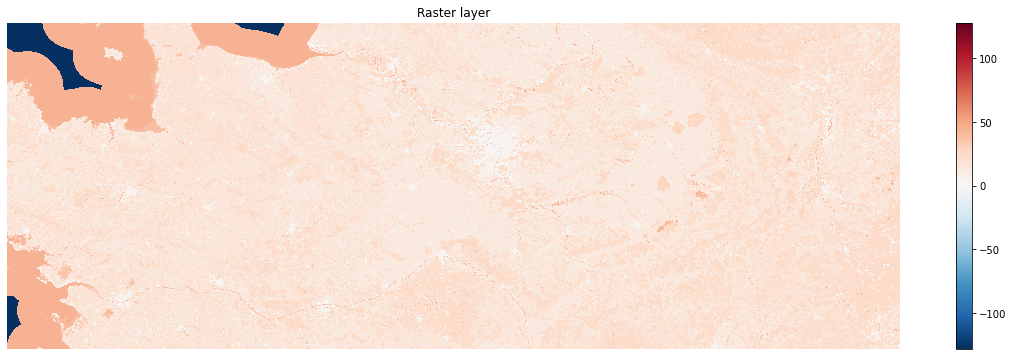

In [60]:
import rioxarray as rxr

# raster = rxr.open_rasterio('data/france-zone-1.tif', masked=True).squeeze()
raster = rxr.open_rasterio('data/france-zone-1.tif').squeeze()
f, ax = plt.subplots(figsize=(20, 6))
raster.plot.imshow(ax=ax)
ax.set(title="Raster layer")
ax.set_axis_off()
plt.show()

**Interrogation**: à quoi servent les autres données (`U2018_CLC2018_V2020_20u1.tif.ovr`, `U2018_CLC2018_V2020_20u1.tfw`...) ?

### Association vector - raster

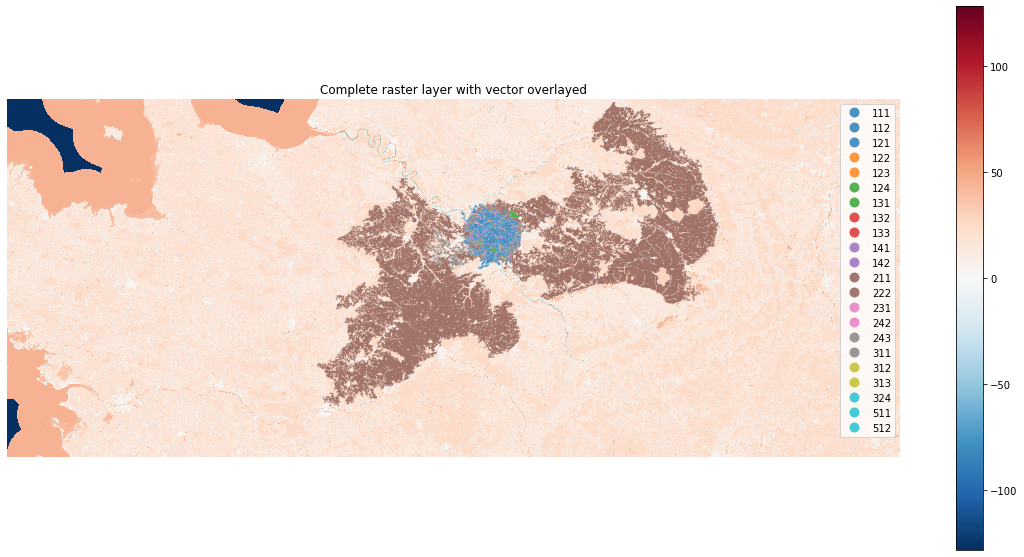

In [61]:
f, ax = plt.subplots(figsize=(20, 10))

raster.plot.imshow(ax=ax)

gdf.plot(column="Code_18", legend=True, ax=ax, alpha=.8)

ax.set(title="Complete raster layer with vector overlayed")

ax.set_axis_off()
plt.show()

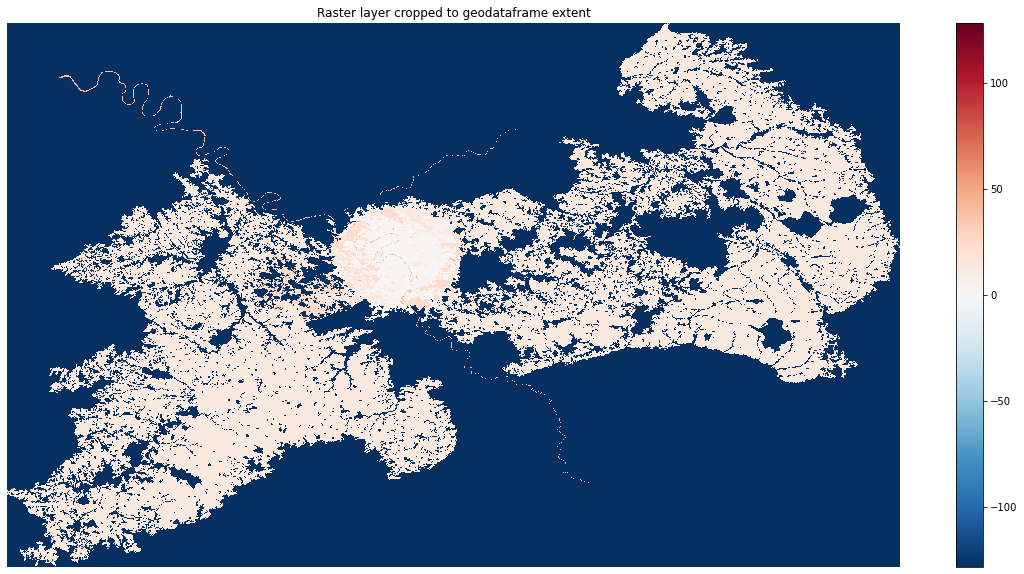

In [62]:
from shapely.geometry import mapping

raster_clipped = raster.rio.clip(gdf.geometry.apply(mapping),
                                 # This is needed if your GDF is in a diff CRS than the raster data
                                 gdf.crs)

f, ax = plt.subplots(figsize=(20, 10))
raster_clipped.plot(ax=ax)
ax.set(title="Raster layer cropped to geodataframe extent")
ax.set_axis_off()
plt.show()

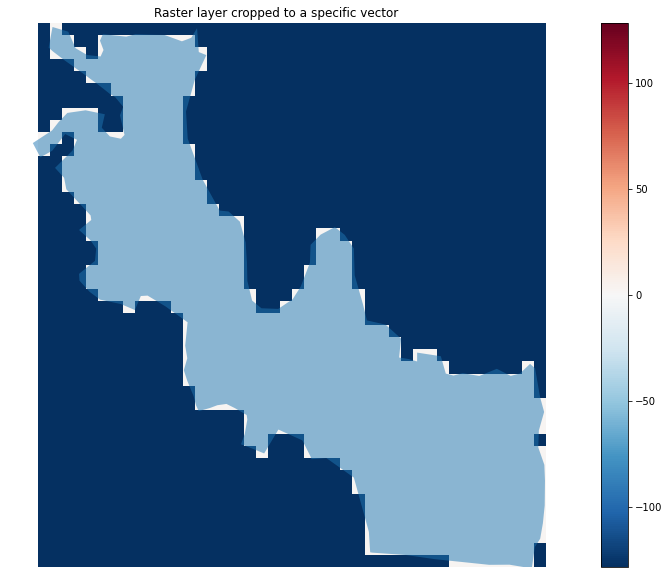

In [63]:
test = raster.rio.clip(gdf.geometry[1].geoms)

f, ax = plt.subplots(figsize=(20, 10))

test.plot.imshow(ax=ax)

gdf.loc[[1], 'geometry'].plot(ax=ax, alpha=.5)

ax.set(title="Raster layer cropped to a specific vector")

ax.set_axis_off()
plt.show()

Les données raster n'ont finalement pas l'air d'ếtre intéressantes à exploiter car on ne dispose pas de données RGB propres à chaque pixel. En effet, il semble que l'on dispose uniquement de valeurs RGB associées de manière générale aux codes CLC.

## Construction du graphe

In [64]:
neighborhood = pd.read_csv("data/france-zone-1-neighborhood.csv")